In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_selection import RFECV, chi2
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from imblearn.over_sampling import SMOTE
from scipy.stats import bootstrap
from prettytable import PrettyTable

In [2]:
directory = "..data/AReM"

# **1. Time Series Classification Part 1: Feature Creation/Extraction**

## a) Download and read the dataset

In [3]:
def cleaning_dataset4(df):
  """
    Function to clean the dataset 4 of bending2 folder
  """
  cols = ['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13',
        'avg_rss23', 'var_rss23']
  cleaned_vals = {}
  for feature in cols:
    cleaned_vals[feature] = []

  for row in df["# Columns: time"]:
    vals = row.split(" ")
    vals = vals[:-1]
    i = 0
    for feature in cleaned_vals:
      cleaned_vals[feature].append(vals[i])
      i += 1
    
  return pd.DataFrame(cleaned_vals)

In [4]:
folders = []
for filename in os.listdir(directory):
    if not filename.endswith(".pdf"):
      f = os.path.join(directory, filename)
      folders.append(f)

In [5]:
folder = folders[0]

dataframes_loc = []
for folder in folders:
  for filename in os.listdir(folder):  
      f = os.path.join(folder, filename)
      # df = pd.read_csv(f,  skiprows=4, usecols = ['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13',
      #   'avg_rss23', 'var_rss23'])
      # if(folder.split("/")[-1]=="bending2" and filename=="dataset4.csv"):
      #   df = cleaning_dataset4(df)
      
      dataframes_loc.append(f)


      #print(f, len(df))
  

## b) Train Test Split

In [6]:
def train_test_split(dfs):
  train_dfs_loc = []
  test_dfs_loc = []

  for loc in dfs:
    tmp = loc.split("/")
    if(tmp[-2]=="bending1" or tmp[-2]=="bending2"):
      if(int(tmp[-1].split(".")[0][7:])<=2):
        test_dfs_loc.append(loc)
      else:
        train_dfs_loc.append(loc)
        
    else:
      if(int(tmp[-1].split(".")[0][7:])<=3):
        test_dfs_loc.append(loc)
      else:
        train_dfs_loc.append(loc)
      
  return (train_dfs_loc,test_dfs_loc)

In [7]:
train_dfs_loc, test_dfs_loc = train_test_split(dataframes_loc)

In [8]:
def get_dataframes(train_dfs_loc, test_dfs_loc):
  # First 69 rows are train data and next 19 rows are test data
  dataframes = []
  bending = []
  classes = []
  class_mapping = {"bending1": 0, "bending2": 1, "cycling": 2, "lying": 3, "sitting": 4, "standing": 5, "walking": 6}

  for f in train_dfs_loc:
    df = pd.read_csv(f,  skiprows=4, usecols = ['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13',
      'avg_rss23', 'var_rss23'])
    if(f.split("/")[-2]=="bending2" and f.split("/")[-1]=="dataset4.csv"):
      df = cleaning_dataset4(df)
    if(f.split("/")[-2]=="bending2" or f.split("/")[-2]=="bending1"):
      bending.append(1)
    else:
      bending.append(0)
    dataframes.append(df)
    classes.append(class_mapping[f.split("/")[-2]])

  for f in test_dfs_loc:
    df = pd.read_csv(f,  skiprows=4, usecols = ['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13',
      'avg_rss23', 'var_rss23'])
    if(f.split("/")[-2]=="bending2" or f.split("/")[-2]=="bending1"):
      bending.append(1)
    else:
      bending.append(0)
    dataframes.append(df)
    classes.append(class_mapping[f.split("/")[-2]])  

  return (dataframes,bending,classes)


In [9]:
# First 69 rows are train data and next 19 rows are test data
dataframes,bending,classes = get_dataframes(train_dfs_loc, test_dfs_loc)

## c) Feature Extraction

### i) **Q.** What types of time-domain features are usually used in time series classification?

**Simple Statistical Features** <br>
1. Maximum
2. Minimum
3. Mean
4. Median
5. Standard Deviation
6. Quartile Ranges

**Frequency Domain Features** <br>
1. k-peaks in amplitude in the *Discrete Fourier Transform*
2. k-quartiles of these *DFTs*. 

**Time Series Analysis Features** <br>
1. Cross-correlation between each dimestion and Auto-correlation.
2. Orders of the autoregressive (AR), integrated (I) and moving average (MA) part of an estimated *ARIMA* model.
3. Parameters of Auto Regressor
4. Parameters of Moving Average





### ii) Extracting the time domain features

In [10]:
cols = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13',
        'avg_rss23', 'var_rss23']

In [11]:
new_dataframe = {}
i = 0
for df in dataframes:
  data = []
  for c in cols:
    sr = df.astype(float).describe()[c][1:].reindex(['min','max','mean','50%','std','25%','75%'])
    sr.index = ['min','max','mean','median','std dev','1st quart','3rd quart']
    data.extend(sr.values)
  new_dataframe[i] = data
  i+=1
  #print(len(data))

In [12]:
col_names = []

for i in range(1,7):
  for c in ['min','max','mean','median','std dev','1st quart','3rd quart']:
    col_names.append(c+str(i))

In [13]:
features = pd.DataFrame(new_dataframe).swapaxes("index", "columns")
features.index = np.arange(1,len(features)+1)
features.index.name = "Instance"
features.columns = col_names
features

,min1,max1,mean1,median1,std dev1,1st quart1,3rd quart1,min2,max2,mean2,...,std dev5,1st quart5,3rd quart5,min6,max6,mean6,median6,std dev6,1st quart6,3rd quart6
Instance,,,,,,,,,,,,,,,,,,,,,
1,23.50,30.00,27.716375,27.500,1.442253,27.00,29.00,0.0,1.79,0.363687,...,4.074511,5.5000,10.75,0.0,4.50,0.734271,0.71,0.613688,0.43,1.00
2,23.50,30.00,27.716375,27.500,1.442253,27.00,29.00,0.0,1.79,0.363687,...,4.074454,5.5000,10.75,0.0,4.50,0.735396,0.71,0.612834,0.43,1.00
3,48.00,48.25,48.004167,48.000,0.032038,48.00,48.00,0.0,0.43,0.007167,...,3.268502,4.6700,10.00,0.0,2.50,0.641229,0.50,0.388372,0.46,0.83
4,39.00,41.00,39.667833,39.500,0.280158,39.50,39.75,0.0,1.00,0.583604,...,4.097351,1.6275,9.33,0.0,3.49,0.635938,0.50,0.608399,0.00,0.83
5,39.00,56.25,47.325125,42.670,5.961280,42.00,54.00,0.0,8.49,0.274313,...,4.142132,11.7500,18.00,0.0,5.72,0.766167,0.50,0.723953,0.43,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,44.50,46.75,45.239667,45.000,0.429915,45.00,45.33,0.0,1.00,0.172958,...,2.945840,17.6275,21.00,0.0,8.20,0.837250,0.71,0.835344,0.43,1.12
85,33.25,48.00,42.363563,43.000,2.068247,42.00,43.50,0.0,4.44,0.492563,...,4.956821,10.1875,17.69,0.0,6.02,1.034021,0.83,0.985627,0.47,1.25
86,37.00,50.75,45.917667,45.635,1.089027,45.00,46.50,0.0,4.87,0.324542,...,3.585511,16.5000,21.00,0.0,7.22,0.904604,0.71,0.896171,0.43,1.12


### iii) Standard Deviation of each of the time-domain features

In [14]:
table = PrettyTable(["Feature Name", "Calculated Std Dev", "Low Std on CI", "High Std on CI"])
for c in features.columns:
  feature_std = np.std(np.asarray(features[c]))
  bootstrap_ci = bootstrap((np.asarray(features[c]),), np.std, confidence_level=0.9,
                         random_state=1, method='percentile')
  ci = bootstrap_ci.confidence_interval
  table.add_row([c, "%.4f"%feature_std, "%.4f"%ci[0], "%.4f"%ci[1]])
  #print(bootstrap_ci.confidence_interval)

In [15]:
print(table)

+--------------+--------------------+---------------+----------------+
| Feature Name | Calculated Std Dev | Low Std on CI | High Std on CI |
+--------------+--------------------+---------------+----------------+
|     min1     |       9.5154       |     8.2104    |    10.7083     |
|     max1     |       4.3693       |     3.3088    |     5.2646     |
|    mean1     |       5.3053       |     4.6732    |     5.8519     |
|   median1    |       5.4091       |     4.7600    |     5.9745     |
|   std dev1   |       1.7621       |     1.5625    |     1.9402     |
|  1st quart1  |       6.1185       |     5.5427    |     6.6078     |
|  3rd quart1  |       5.1096       |     4.2999    |     5.8121     |
|     min2     |       0.0000       |     0.0000    |     0.0000     |
|     max2     |       5.0339       |     4.5957    |     5.3749     |
|    mean2     |       1.5652       |     1.3864    |     1.6956     |
|   median2    |       1.4042       |     1.2293    |     1.5350     |
|   st

### iv) Three most important time-domain features


The three most important time-domain features according to me are: **mean, standard deviation and median**. 
<br>
Mean and standard deviation are important because they show the average value and how much the distribution varies form the mean, which can help understand the distribution of data. Median helps in knowing the centre of distribution.

# **2. Time Series Classification Part 2: Binary and Multiclass Classification**

## a) Binary Classification Using Logistic Regression

### i. Scatter Plots

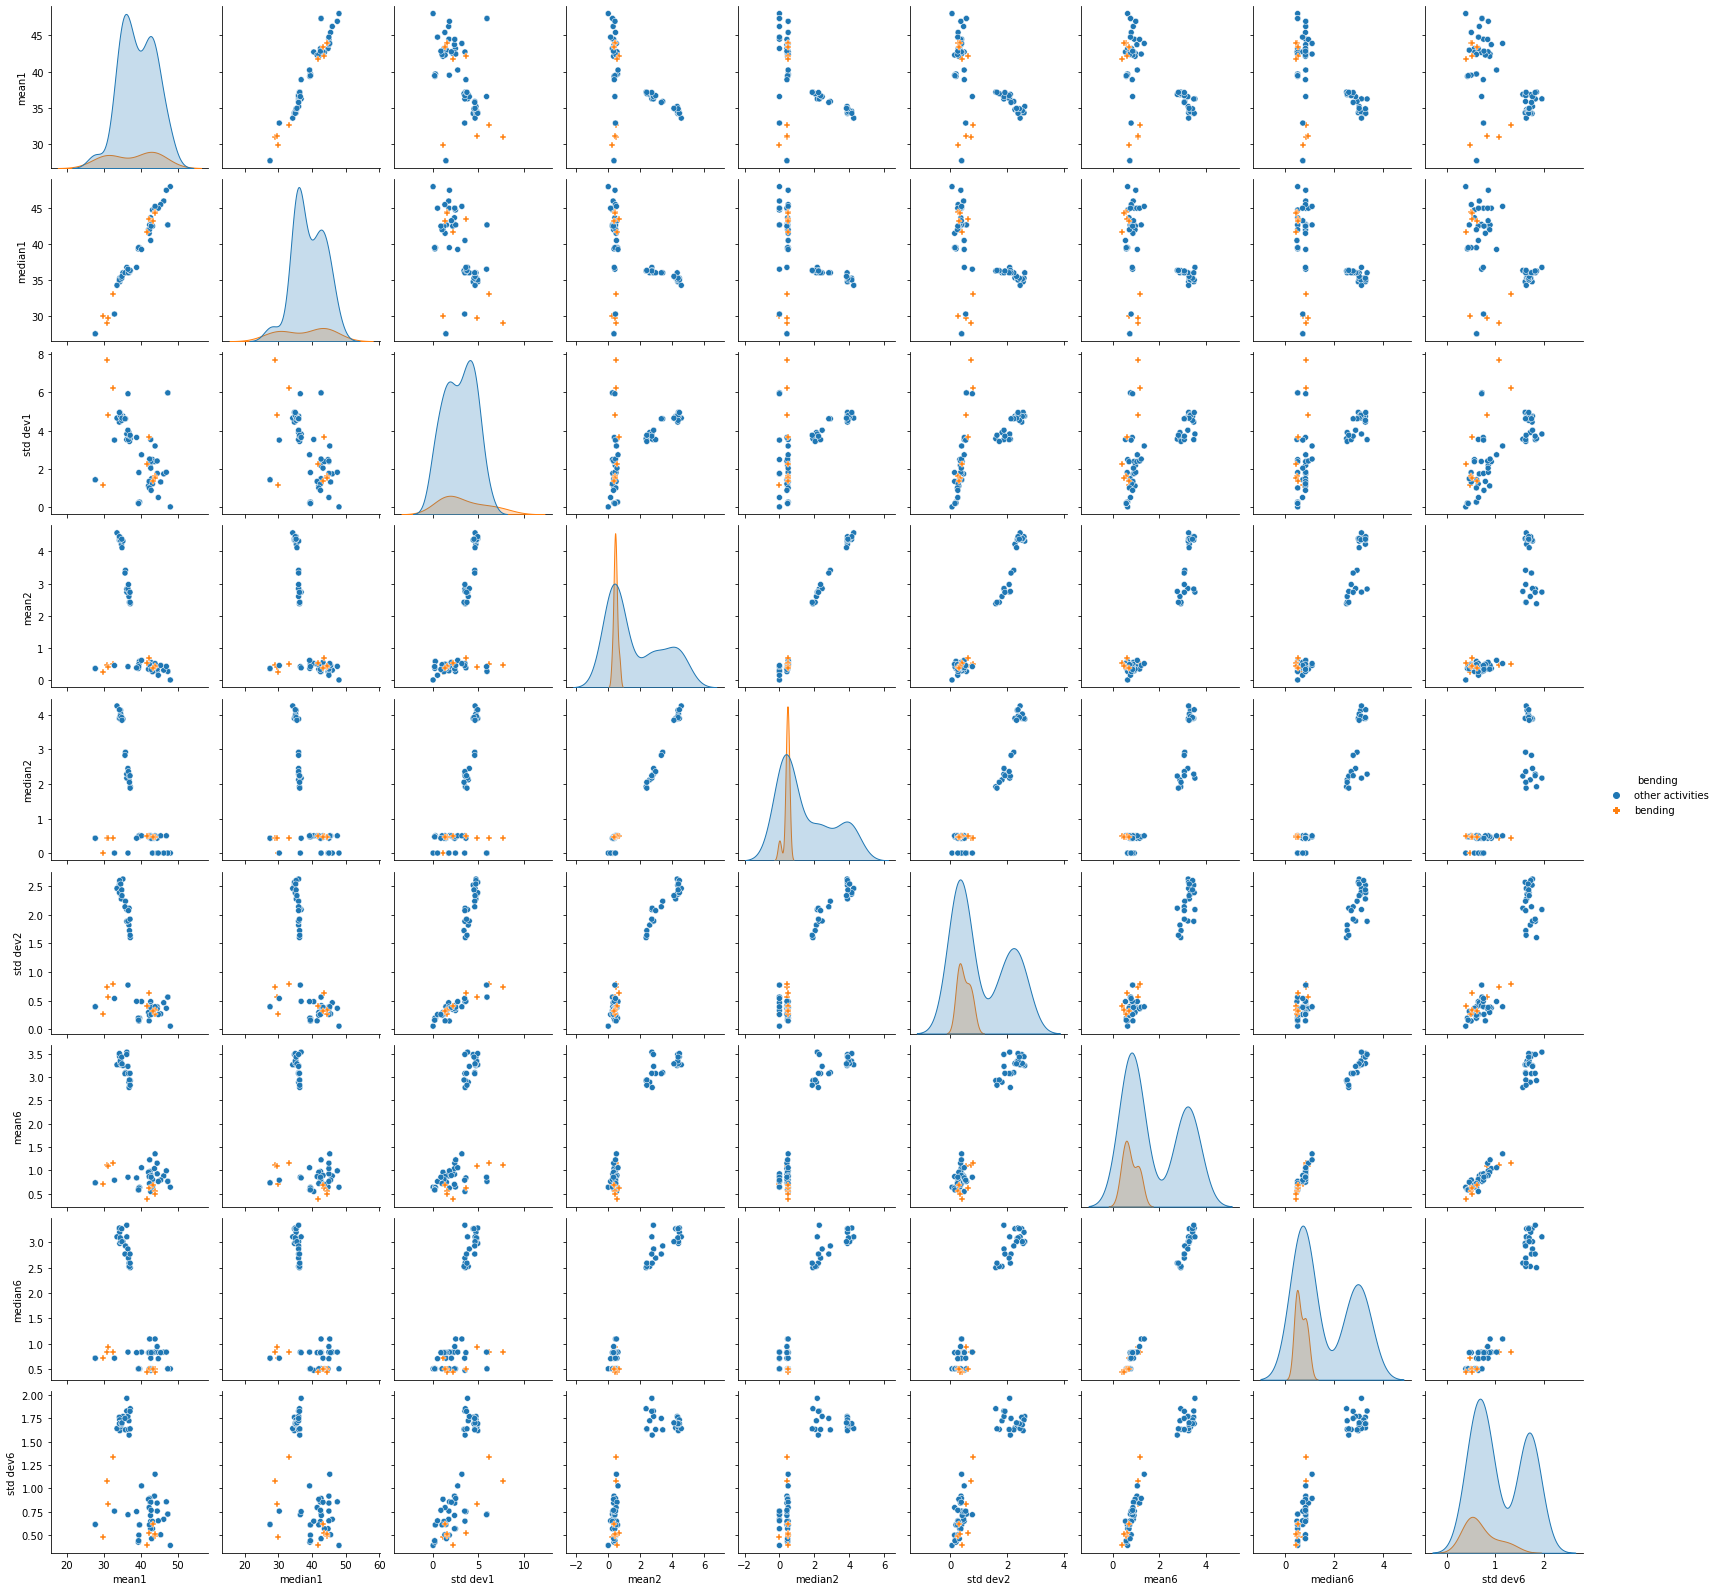

In [16]:
required_features = ['mean1','median1','std dev1','mean2','median2','std dev2','mean6','median6','std dev6']
tmp = features[:69][required_features]
tmp["bending"] = ["bending" if x==1 else "other activities" for x in bending][:69]
sns.pairplot(tmp, hue='bending', markers=['o','P'])

### ii. Break each time series in your training set into two (approximately) equal length time series. Repeat the experiment in 2(a)i

In [17]:
def break_in_l(dataframes, l, cols):
  new_dataframe = {}
  i = 0
  for df in dataframes:
    data = []
    dfs_to_concat = []
    n = len(df)
    new_df = df.iloc[int(n/l)*0:int(n/l)*(1)]
    dfs_to_concat.append(new_df)
    new_df.drop('# Columns: time', inplace=True, axis=1)
    for l1 in range(1,l):
      tmp = df[int(n/l)*l1:int(n/l)*(l1+1)]
      tmp.reset_index(inplace=True, drop=True)
      tmp.drop('# Columns: time', inplace=True, axis=1)
      dfs_to_concat.append(tmp)
      #new_df = pd.DataFrame(np.concatenate((new_df.values,tmp.values),axis=1))
      #new_df = pd.concat([new_df,tmp],axis=1)
    new_df = pd.concat(dfs_to_concat,axis=1)
    new_df.columns = [i for i in range(len(new_df.columns))]
    for c in new_df.columns:
      #sr = new_df.astype(float).describe()[c][1:].reindex(['min','max','mean','50%','std','25%','75%'])
      #sr.index = ['min','max','mean','median','std dev','1st quart','3rd quart']
      sr = new_df.astype(float).describe()[c][1:].reindex(['mean','50%','std'])
      sr.index = ['mean','median','std dev']
      data.extend(sr.values)
    new_dataframe[i] = data
    i+=1
    
    #print(new_df)
    # if(i==1):
    #   break
  col_names = []
  for i in range(1,l*6+1):
    #for c in ['min','max','mean','median','std dev','1st quart','3rd quart']:
    for c in ['mean','median','std dev']:
        col_names.append(c+str(i))

  features = pd.DataFrame(new_dataframe).swapaxes("index", "columns")
  features.index = np.arange(1,len(features)+1)
  features.index.name = "Instance"
  features.columns = col_names
  
  return features
  #i+=1

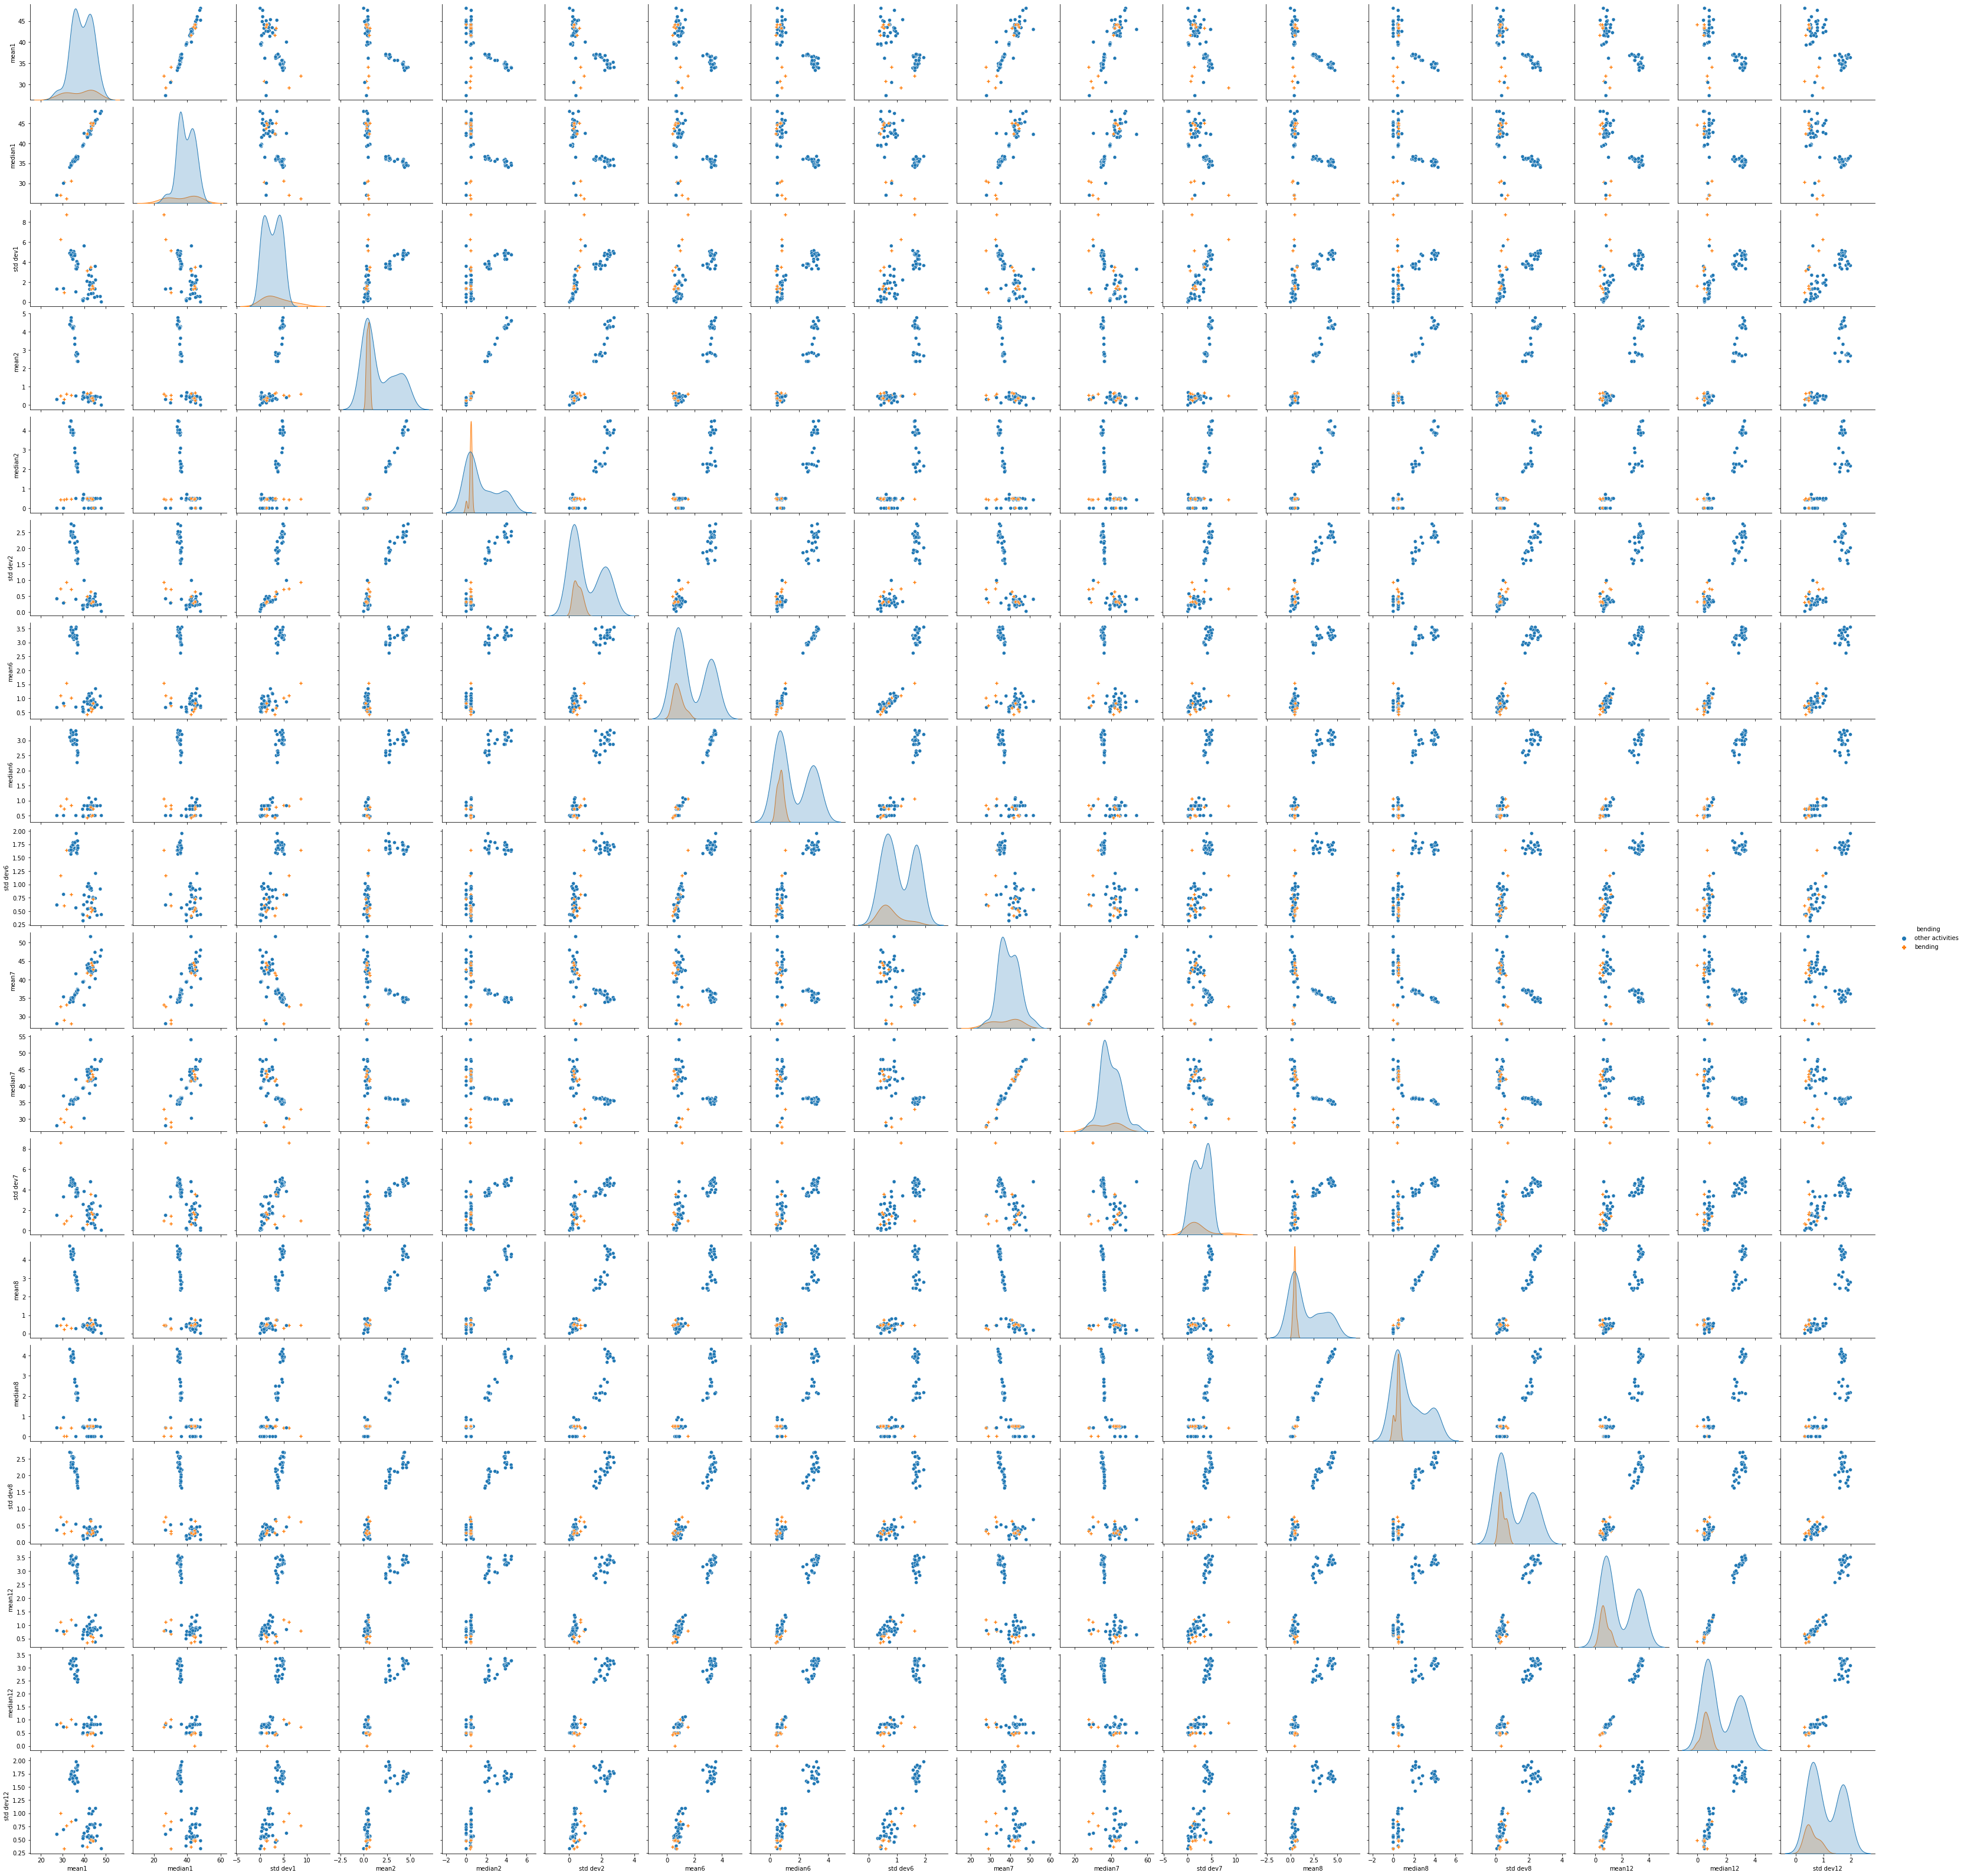

In [18]:
required_features = ['mean1','median1','std dev1','mean2','median2','std dev2','mean6','median6','std dev6','mean7','median7','std dev7','mean8','median8','std dev8','mean12','median12','std dev12']
tmp = break_in_l(dataframes,2,cols)[:69][required_features]
tmp["bending"] = ["bending" if x==1 else "other activities" for x in bending][:69]
sns.pairplot(tmp, hue='bending', markers=['o','P'])

In [19]:
# Slicing the timeframes into l different parts and saving it to reduce the time complexity
for i in range(1,21):
  d = break_in_l(dataframes, l, cols)
  d.to_csv("..data/DataFrames/" + str(l) +".csv")

'\n# Slicing the timeframes into l different parts and saving it to reduce the time complexity\nfor i in range(1,21):\n  d = break_in_l(dataframes, l, cols)\n  d.to_csv("/content/drive/MyDrive/MLDS/MLDS_HW3/DataFrames/" + str(l) +".csv")\n'

**Q** Do you see any considerable difference in the results with those of 2(a)i? <br>
**Ans:** No there is no considerable difference from 2(a) i.

### iii. Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features.

In [20]:
table = PrettyTable(["L", "P", "Cross Val Score"])
best_l = -1
best_cvs = -1
best_p = []
for l in range(1,21):
  #print(l)
  #data = break_in_l(dataframes, l, cols)
  data = pd.read_csv("..data/DataFrames/" + str(l) +".csv")
  data.drop("Instance", inplace=True, axis=1)
  stratified_cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
  lr = LogisticRegression(max_iter=100)
  rfecv = RFECV(estimator=lr, step=1, cv=stratified_cv, min_features_to_select=1, n_jobs=-1)
  rfecv.fit(data[:69],bending[:69])
  cvs = rfecv.cv_results_["mean_test_score"][rfecv.n_features_-1]
  new_df = data.iloc[:, rfecv.support_]

  if(cvs>best_cvs):
    best_cvs = cvs
    best_l = l
    best_p = rfecv.support_
  table.add_row([l, rfecv.n_features_, cvs])
  

In [21]:
print(table)

+----+-----+--------------------+
| L  |  P  |  Cross Val Score   |
+----+-----+--------------------+
| 1  |  2  | 0.9274725274725275 |
| 2  |  2  | 0.9274725274725275 |
| 3  |  1  | 0.9714285714285715 |
| 4  |  1  | 0.9417582417582417 |
| 5  |  1  | 0.9571428571428571 |
| 6  |  1  | 0.9571428571428571 |
| 7  |  4  | 0.9560439560439562 |
| 8  |  4  | 0.9560439560439562 |
| 9  |  34 | 0.956043956043956  |
| 10 |  1  | 0.9571428571428571 |
| 11 |  1  | 0.9714285714285715 |
| 12 |  84 | 0.9714285714285715 |
| 13 |  4  | 0.9714285714285715 |
| 14 |  1  | 0.9714285714285715 |
| 15 |  1  | 0.9714285714285715 |
| 16 |  8  | 0.9714285714285715 |
| 17 |  83 | 0.9857142857142858 |
| 18 | 104 | 0.9714285714285715 |
| 19 |  11 | 0.9857142857142858 |
| 20 |  1  | 0.9714285714285715 |
+----+-----+--------------------+


**Q** Explain what the right way and the wrong way are to perform cross-validation in this problem. <br>
**Ans:** The correct way to perform cross-validation is to divide the training set into k-folds. Use k-1 folds for training and the remaining one for testing. Repeat this process k times and then find the value of hyperparameters for the model based on the model which gave the highest CV score. Then again train this model with tuned hyper-parameters with the entire training set for further analysis on the test set.

### iv. Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.


 TRAINING DATA 

Best l: 17
Best p: 83
Best Params: Index(['mean5', 'median5', 'std dev7', 'median10', 'mean11', 'median11',
       'mean12', 'median12', 'std dev13', 'mean17', 'median17', 'std dev17',
       'mean18', 'mean23', 'median23', 'std dev25', 'mean26', 'mean29',
       'median29', 'mean31', 'median31', 'std dev31', 'mean32', 'median33',
       'mean35', 'median35', 'mean36', 'median36', 'mean39', 'median39',
       'std dev43', 'mean45', 'std dev45', 'mean48', 'mean55', 'median55',
       'std dev55', 'mean56', 'median59', 'mean61', 'median61', 'std dev61',
       'mean62', 'mean64', 'mean66', 'mean67', 'median67', 'std dev67',
       'mean69', 'median69', 'std dev69', 'mean70', 'median70', 'std dev71',
       'mean72', 'mean73', 'median73', 'std dev73', 'mean74', 'mean75',
       'median75', 'mean76', 'median76', 'mean78', 'mean79', 'median79',
       'mean80', 'median80', 'mean84', 'median85', 'std dev85', 'mean87',
       'median87', 'mean89', 'std dev91', 'mean93', 'mean

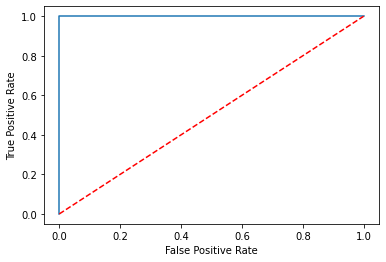



Area Under Curve: 1.0 

       Params     Coeff      P Values
0       mean5  0.088291  2.973391e-17
1     median5  0.084290  1.005297e-16
2    std dev7 -0.039857  2.763978e-02
3    median10 -0.031944  2.044633e-02
4      mean11  0.144179  3.968857e-21
..        ...       ...           ...
78   median95  0.081411  5.176239e-10
79     mean96 -0.037247  8.868966e-03
80    mean100 -0.036278  1.325378e-02
81  median100 -0.035468  1.038856e-02
82  median101  0.057931  8.938486e-09

[83 rows x 3 columns]


In [22]:
print(" TRAINING DATA \n")

data = pd.read_csv("..data/DataFrames/" + str(best_l) +".csv")
data.drop("Instance", inplace=True, axis=1)
data = data.iloc[:, best_p]
lr = LogisticRegression(max_iter=100)
lr.fit(data[:69],bending[:69])

print("Best l:",best_l)
print("Best p:",len(data.columns))
print("Best Params:",data.columns, "\n")

trainPred = lr.predict(data[:69])

print("Confusion Matrix:")
print(confusion_matrix(bending[:69], trainPred))
print("\n")

fpr, tpr, threshold = roc_curve(bending[:69], trainPred)
roc_auc = auc(fpr,tpr)

print("Roc Curve")
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print("\n")
print("Area Under Curve:", roc_auc, "\n")

score, p_vals = chi2(data[:69],bending[:69])
print(pd.DataFrame({"Params":data.columns, "Coeff":lr.coef_[0] , "P Values":p_vals}))


### v. Test the classifier on the test set.

 TEST DATA 

Accuracy Score:
0.9473684210526315 

Confusion Matrix:
[[15  0]
 [ 1  3]]


Roc Curve


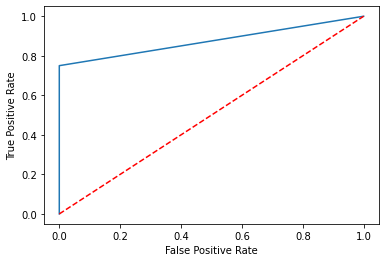



Area Under Curve: 0.875 



In [23]:
print(" TEST DATA \n")

testPred = lr.predict(data[69:])
print("Accuracy Score:")
print(accuracy_score(bending[69:], testPred),"\n")

print("Confusion Matrix:")
print(confusion_matrix(bending[69:], testPred))
print("\n")

fpr, tpr, threshold = roc_curve(bending[69:], testPred)
roc_auc = auc(fpr,tpr)

print("Roc Curve")
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print("\n")
print("Area Under Curve:", roc_auc, "\n")

**Q** Compare the accuracy on the test set with the cross-validation accuracy you obtained previously. <br>
**Ans** The accuracy on the test set is 94.73% which is lower than the training set accuracy of 100%, as it is misclassifying one data-point in the test set. 

### vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?


**Yes**. During training the statsmodel is throwing a error of PerfectSeperation, which means the classes are well seperated to cause instability.

In [24]:
# Statsmodel throws an error
#log_reg = sm.Logit(bending[:69], data[:69]).fit()

### vii. From the confusion matrices you obtained, do you see imbalanced classes?

Yes we can clearly see the imbalance between two classes. For training we have 60 instances of other-activities and only 9 instance of bending class.The bending class is a minority class.

In [25]:
def UpSampleData(data, labels, ratio):
    smote = SMOTE(sampling_strategy=ratio,random_state=0)
    X_resampled, y_resampled= smote.fit_resample(data,labels)
    return X_resampled, y_resampled

In [26]:
table = PrettyTable(["L", "P", "Cross Val Score"])
best_l = -1
best_cvs = -1
best_p = []
for l in range(1,21):
  #print(l)
  #data = break_in_l(dataframes, l, cols)
  data = pd.read_csv("..data/DataFrames/" + str(l) +".csv")
  data.drop("Instance", inplace=True, axis=1)
  stratified_cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
  lr = LogisticRegression(max_iter=100)
  rfecv = RFECV(estimator=lr, step=1, cv=stratified_cv, min_features_to_select=1, n_jobs=-1)
  resampled_data, resampled_labels = UpSampleData(data[:69], bending[:69], 0.5)
  rfecv.fit(resampled_data, resampled_labels)
  cvs = rfecv.cv_results_["mean_test_score"][rfecv.n_features_-1]
  new_df = data.iloc[:, rfecv.support_]

  if(cvs>best_cvs):
    best_cvs = cvs
    best_l = l
    best_p = rfecv.support_
  table.add_row([l, rfecv.n_features_, cvs])

In [27]:
print(table)

+----+----+--------------------+
| L  | P  |  Cross Val Score   |
+----+----+--------------------+
| 1  | 7  | 0.9777777777777779 |
| 2  | 22 | 0.9666666666666666 |
| 3  | 3  | 0.9777777777777779 |
| 4  | 4  | 0.9777777777777779 |
| 5  | 6  | 0.9888888888888889 |
| 6  | 9  | 0.9888888888888889 |
| 7  | 4  | 0.9777777777777779 |
| 8  | 4  | 0.9777777777777779 |
| 9  | 9  | 0.9888888888888889 |
| 10 | 12 |        1.0         |
| 11 | 14 | 0.9888888888888889 |
| 12 | 14 |        1.0         |
| 13 | 2  | 0.9888888888888889 |
| 14 | 5  | 0.9888888888888889 |
| 15 | 5  | 0.9888888888888889 |
| 16 | 5  |        1.0         |
| 17 | 4  |        1.0         |
| 18 | 3  |        1.0         |
| 19 | 20 |        1.0         |
| 20 | 3  |        1.0         |
+----+----+--------------------+


 TRAINING DATA 

Best l: 10
Best p: 12
Best Params: Index(['mean5', 'median5', 'mean11', 'median11', 'mean17', 'median19',
       'mean21', 'median31', 'std dev31', 'std dev37', 'mean43', 'mean53'],
      dtype='object') 

Confusion Matrix:
[[60  0]
 [ 0  9]]


Roc Curve


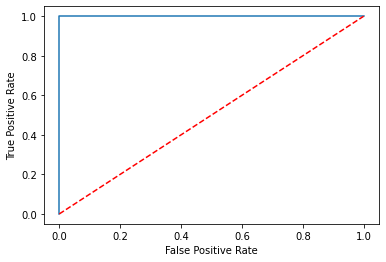



Area Under Curve: 1.0 



In [28]:
print(" TRAINING DATA \n")

data = pd.read_csv("..data/DataFrames/" + str(best_l) +".csv")
data.drop("Instance", inplace=True, axis=1)
data = data.iloc[:, best_p]
resampled_data, resampled_labels = UpSampleData(data[:69], bending[:69], 0.5)
lr_smote = LogisticRegression(max_iter=100)
lr_smote.fit(data[:69],bending[:69])

print("Best l:",best_l)
print("Best p:",len(data.columns))
print("Best Params:",data.columns, "\n")

trainPred = lr_smote.predict(data[:69])

print("Confusion Matrix:")
print(confusion_matrix(bending[:69], trainPred))
print("\n")

fpr, tpr, threshold = roc_curve(bending[:69], trainPred)
roc_auc = auc(fpr,tpr)

print("Roc Curve")
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print("\n")
print("Area Under Curve:", roc_auc, "\n")

#score, p_vals = chi2(data[:69],bending[:69])
#print(pd.DataFrame({"Params":data.columns, "Coeff":lr.coef_[0] , "P Values":p_vals}))
# testPred = lr_smote.predict(data[69:])
# print("Accuracy Score:")
# print(accuracy_score(bending[69:], testPred))
# print("\n")

 TEST DATA 

Accuracy Score:
0.9473684210526315 

Confusion Matrix:
[[15  0]
 [ 1  3]]


Roc Curve


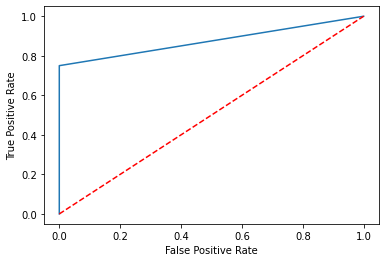



Area Under Curve: 0.875 



In [29]:
print(" TEST DATA \n")

testPred = lr_smote.predict(data[69:])
print("Accuracy Score:")
print(accuracy_score(bending[69:], testPred),"\n")

print("Confusion Matrix:")
print(confusion_matrix(bending[69:], testPred))
print("\n")

fpr, tpr, threshold = roc_curve(bending[69:], testPred)
roc_auc = auc(fpr,tpr)

print("Roc Curve")
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print("\n")
print("Area Under Curve:", roc_auc, "\n")

## b) Binary Classification Using L1-penalized logistic regression

### i. Repeat 2(a)iii using L1-penalized logistic regression

In [30]:
def l1_regularized_cv(scaler, table, sc, labels, solver):
  best_l = -1
  best_cvs = -1
  best_p = -1
  best_c = 10000000
  best_params = []
  for l in range(1,21):
    p = -1
    #print(l)
    #data = break_in_l(dataframes, l, cols)
    data = pd.read_csv("..data/DataFrames/" + str(l) +".csv")
    data.drop("Instance", inplace=True, axis=1)
    scaled_data = scaler.fit_transform(data[:69])
    data = pd.DataFrame(scaled_data, columns=data.columns)
    stratified_cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
    lr = LogisticRegressionCV(cv=stratified_cv, penalty='l1', solver=solver, random_state=1, max_iter=100, n_jobs=-1)
    lr.fit(data[:69],labels[:69])
    c = lr.C_[0]
    c_ind = -1
    for i in range(len(lr.Cs_)):
        if i==c:
            c_ind=i
    cvs = np.mean(lr.scores_[1][:,c_ind])
    p = sum([1 if x!= 0 else 0 for x in lr.coef_[0]])
    #lr.feature_names_in_
    if(cvs>best_cvs):
      best_cvs = cvs
      best_l = l
      best_p = p
      best_c = lr.C_[0]
      best_params = [True if x!= 0 else False for x in lr.coef_[0]]

    table.add_row([l, p, lr.C_[0], cvs, sc])
  return table,best_l, best_p, best_c, best_params

In [31]:
def print_data_on_scaler(scaler, name, labels, solver):
  table = PrettyTable(["L", "P", "C", "Cross Val Score", "Scaler"])
  table,l,p,c, best_p = l1_regularized_cv(scaler, table, name, labels, solver)
  data = pd.read_csv("..data/DataFrames/" + str(l) +".csv")
  data.drop("Instance", inplace=True, axis=1)
  data = data.iloc[:, best_p]
  scaled_data = scaler.fit_transform(data[:69])
  scaled_data = pd.DataFrame(scaled_data, columns=data.columns)
  lr = LogisticRegression(C=c, penalty='l1', solver=solver, max_iter=100)
  lr.fit(scaled_data,labels[:69])

  print(" " + name.upper() + " \n")
  print("Best l:",l)
  print("Best p:",len(data.columns))
  print("Best C:", c)
  print("Best Params:",data.columns, "\n")
  trainPred = lr.predict(scaled_data)
  print("Accuracy Score:")
  print(accuracy_score(labels[:69], trainPred),"\n")

  print("Train Error")
  print(1 - accuracy_score(labels[:69], trainPred),"\n")

  print("Confusion Matrix:")
  print(confusion_matrix(labels[:69], trainPred))
  print("\n")

  #FOR MULTICLASS THIS IS DIFFERENT

  if(solver=='liblinear'):
    fpr, tpr, threshold = roc_curve(labels[:69], trainPred)
    roc_auc = auc(fpr,tpr)

    print("Roc Curve")
    plt.plot(fpr,tpr)
    plt.plot([0,1], [0,1], 'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print("\n")
    print("Area Under Curve:", roc_auc, "\n")
  else:
    OHTestY = LabelBinarizer().fit_transform(classes)[:69]
    n_classes = len(np.unique(classes[:69]))
    testProb = lr.predict_proba(scaled_data[:69])
    colors = ["violet", "indigo", "blue", "green", "yellow", "orange", "red"]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(OHTestY[:, i], testProb[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class data')
    plt.legend(loc="lower right")
    plt.show()

  print(" TEST DATA \n")

  testPred = lr.predict(scaler.transform(data[69:]))
  print("Accuracy Score:")
  print(accuracy_score(labels[69:], testPred),"\n")

  print("Test Error:")
  print(1 - accuracy_score(labels[69:], testPred),"\n")

  print("Confusion Matrix:")
  print(confusion_matrix(labels[69:], testPred))
  print("\n")

  #FOR MULTICLASS THIS IS DIFFERENT

  if(solver=='liblinear'):
    fpr, tpr, threshold = roc_curve(labels[69:], testPred)
    roc_auc = auc(fpr,tpr)

    print("Roc Curve")
    plt.plot(fpr,tpr)
    plt.plot([0,1], [0,1], 'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print("\n")
    print("Area Under Curve:", roc_auc, "\n")
  else:
    OHTestY = LabelBinarizer().fit_transform(classes)[69:]
    n_classes = len(np.unique(classes[69:]))
    testProb = lr.predict_proba(scaler.transform(data[69:]))
    colors = ["violet", "indigo", "blue", "green", "yellow", "orange", "red"]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(OHTestY[:, i], testProb[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class data')
    plt.legend(loc="lower right")
    plt.show()


  print(table)

 STANDARD SCALER 

Best l: 1
Best p: 6
Best C: 166.81005372000558
Best Params: Index(['mean1', 'median3', 'std dev3', 'mean5', 'std dev5', 'std dev6'], dtype='object') 

Accuracy Score:
1.0 

Train Error
0.0 

Confusion Matrix:
[[60  0]
 [ 0  9]]


Roc Curve


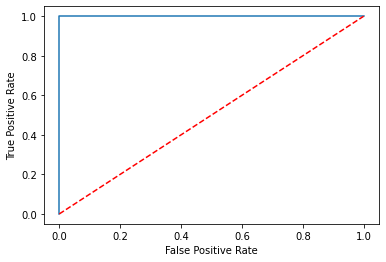



Area Under Curve: 1.0 

 TEST DATA 

Accuracy Score:
1.0 

Test Error:
0.0 

Confusion Matrix:
[[15  0]
 [ 0  4]]


Roc Curve


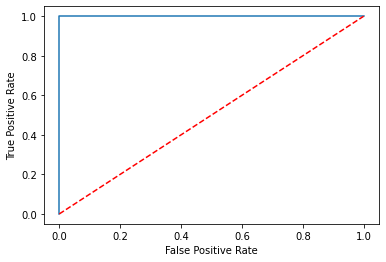



Area Under Curve: 1.0 

+----+----+--------------------+--------------------+-----------------+
| L  | P  |         C          |  Cross Val Score   |      Scaler     |
+----+----+--------------------+--------------------+-----------------+
| 1  | 6  | 166.81005372000558 | 0.9274725274725275 | Standard Scaler |
| 2  | 8  | 21.54434690031882  | 0.8846153846153847 | Standard Scaler |
| 3  | 4  | 0.3593813663804626 | 0.8703296703296705 | Standard Scaler |
| 4  | 11 | 21.54434690031882  | 0.9131868131868133 | Standard Scaler |
| 5  | 8  | 0.3593813663804626 | 0.9131868131868132 | Standard Scaler |
| 6  | 5  | 0.3593813663804626 | 0.8846153846153847 | Standard Scaler |
| 7  | 6  | 0.3593813663804626 | 0.9131868131868132 | Standard Scaler |
| 8  | 8  | 0.3593813663804626 | 0.9131868131868132 | Standard Scaler |
| 9  | 10 | 0.3593813663804626 |        0.9         | Standard Scaler |
| 10 | 13 | 21.54434690031882  | 0.9142857142857143 | Standard Scaler |
| 11 | 12 | 2.782559402207126  | 0.884

In [32]:
scaler = StandardScaler()
print_data_on_scaler(scaler, 'Standard Scaler', bending, 'liblinear')

 NORMAL SCALER 

Best l: 14
Best p: 193
Best C: 10000.0
Best Params: Index(['mean1', 'median1', 'std dev1', 'mean2', 'median2', 'std dev2', 'mean3',
       'median3', 'std dev3', 'mean4',
       ...
       'std dev81', 'mean82', 'median82', 'std dev82', 'mean83', 'median83',
       'std dev83', 'mean84', 'median84', 'std dev84'],
      dtype='object', length=193) 

Accuracy Score:
1.0 

Train Error
0.0 

Confusion Matrix:
[[60  0]
 [ 0  9]]


Roc Curve


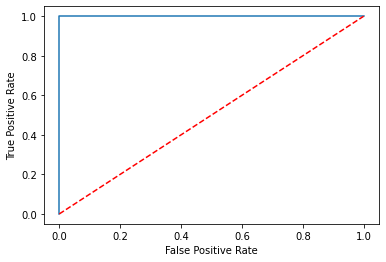



Area Under Curve: 1.0 

 TEST DATA 

Accuracy Score:
0.9473684210526315 

Test Error:
0.052631578947368474 

Confusion Matrix:
[[15  0]
 [ 1  3]]


Roc Curve


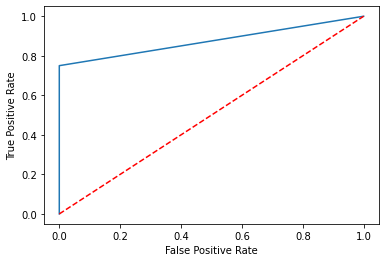



Area Under Curve: 0.875 

+----+-----+-------------------+--------------------+---------------+
| L  |  P  |         C         |  Cross Val Score   |     Scaler    |
+----+-----+-------------------+--------------------+---------------+
| 1  |  4  | 2.782559402207126 | 0.9131868131868132 | Normal Scaler |
| 2  |  8  | 21.54434690031882 | 0.9142857142857143 | Normal Scaler |
| 3  |  7  | 2.782559402207126 | 0.8989010989010989 | Normal Scaler |
| 4  |  8  | 2.782559402207126 | 0.8989010989010989 | Normal Scaler |
| 5  |  16 | 21.54434690031882 | 0.8989010989010989 | Normal Scaler |
| 6  |  6  | 2.782559402207126 | 0.8989010989010989 | Normal Scaler |
| 7  |  15 | 21.54434690031882 | 0.8846153846153847 | Normal Scaler |
| 8  |  11 | 2.782559402207126 | 0.8989010989010989 | Normal Scaler |
| 9  |  12 | 2.782559402207126 | 0.8846153846153847 | Normal Scaler |
| 10 |  10 | 2.782559402207126 | 0.9131868131868132 | Normal Scaler |
| 11 |  12 | 2.782559402207126 | 0.9131868131868133 | Normal S

In [33]:
scaler = MinMaxScaler()
print_data_on_scaler(scaler, 'Normal Scaler', bending, 'liblinear')

### ii. Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?


* L1-Penalized Logistic Regression with Standard Scaled Features is performing better on the test set with 100% accuracy than the variable selection using p-values method with 94.73% accuracy on test set. Also, L1-Penalized Logistic Regression with Normal Scaled Features is giving a similar Accuracy score to the variable selection using p-values method on test set.
<br>
*   L-1 Penalized Logistic Regression is easier to implement as it is selcting the p features on its own. Also, the training time is significantly faster than the p-values method.



## c) Multi-class Classification (The Realistic Case)


### i. Find the best l in the same way as you found it in 2(b)i to build an L1-penalized multinomial regression model to classify all activities in your training set.

 STANDARD SCALER 

Best l: 1
Best p: 5
Best C: 2.782559402207126
Best Params: Index(['mean1', 'median1', 'std dev1', 'mean5', 'median5'], dtype='object') 

Accuracy Score:
0.8405797101449275 

Train Error
0.1594202898550725 

Confusion Matrix:
[[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 11  0  0  0  1]
 [ 0  0  0 10  1  1  0]
 [ 0  1  1  1  7  1  1]
 [ 0  0  0  1  2  9  0]
 [ 0  0  0  0  0  0 12]]




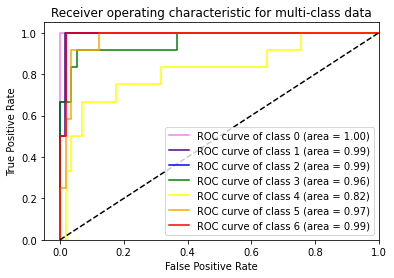

 TEST DATA 

Accuracy Score:
0.8421052631578947 

Test Error:
0.1578947368421053 

Confusion Matrix:
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 1 0 2 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]




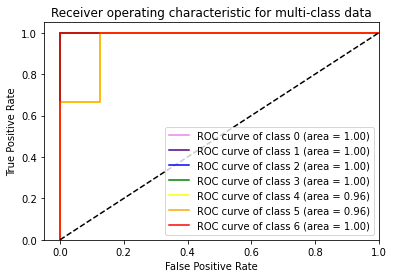

+----+-----+--------------------+--------------------+-----------------+
| L  |  P  |         C          |  Cross Val Score   |      Scaler     |
+----+-----+--------------------+--------------------+-----------------+
| 1  |  5  | 2.782559402207126  | 0.9274725274725275 | Standard Scaler |
| 2  |  8  | 2.782559402207126  | 0.8978021978021978 | Standard Scaler |
| 3  |  54 |      10000.0       | 0.8538461538461538 | Standard Scaler |
| 4  |  70 | 1291.5496650148827 | 0.868131868131868  | Standard Scaler |
| 5  |  38 | 21.54434690031882  | 0.8538461538461538 | Standard Scaler |
| 6  |  45 | 21.54434690031882  | 0.8549450549450549 | Standard Scaler |
| 7  |  8  | 0.3593813663804626 | 0.8252747252747252 | Standard Scaler |
| 8  |  9  | 0.3593813663804626 | 0.8252747252747252 | Standard Scaler |
| 9  |  66 | 21.54434690031882  | 0.8549450549450549 | Standard Scaler |
| 10 |  10 | 0.3593813663804626 | 0.810989010989011  | Standard Scaler |
| 11 | 160 | 166.81005372000558 | 0.796703296703296

In [34]:
scaler = StandardScaler()
print_data_on_scaler(scaler, 'Standard Scaler', classes, 'saga')

 NORMAL SCALER 

Best l: 1
Best p: 18
Best C: 1291.5496650148827
Best Params: Index(['mean1', 'median1', 'std dev1', 'mean2', 'median2', 'std dev2', 'mean3',
       'median3', 'std dev3', 'mean4', 'median4', 'std dev4', 'mean5',
       'median5', 'std dev5', 'mean6', 'median6', 'std dev6'],
      dtype='object') 

Accuracy Score:
0.9855072463768116 

Train Error
0.01449275362318836 

Confusion Matrix:
[[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  0  0 12]]




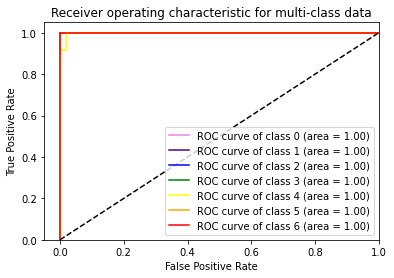

 TEST DATA 

Accuracy Score:
0.9473684210526315 

Test Error:
0.052631578947368474 

Confusion Matrix:
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]




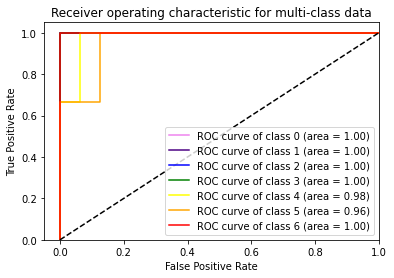

+----+-----+--------------------+--------------------+---------------+
| L  |  P  |         C          |  Cross Val Score   |     Scaler    |
+----+-----+--------------------+--------------------+---------------+
| 1  |  18 | 1291.5496650148827 | 0.9274725274725275 | Normal Scaler |
| 2  |  20 | 21.54434690031882  | 0.9274725274725275 | Normal Scaler |
| 3  |  30 | 21.54434690031882  | 0.8692307692307691 | Normal Scaler |
| 4  |  40 | 21.54434690031882  | 0.8692307692307691 | Normal Scaler |
| 5  |  13 | 2.782559402207126  | 0.8538461538461538 | Normal Scaler |
| 6  |  65 | 21.54434690031882  | 0.810989010989011  | Normal Scaler |
| 7  |  76 | 21.54434690031882  | 0.8263736263736263 | Normal Scaler |
| 8  |  25 | 2.782559402207126  | 0.810989010989011  | Normal Scaler |
| 9  |  30 | 2.782559402207126  | 0.8120879120879121 | Normal Scaler |
| 10 |  31 | 2.782559402207126  | 0.7978021978021979 | Normal Scaler |
| 11 |  36 | 2.782559402207126  | 0.7824175824175824 | Normal Scaler |
| 12 |

In [35]:
scaler = MinMaxScaler()
print_data_on_scaler(scaler, 'Normal Scaler', classes, 'saga')

### ii. Repeat 2(c)i using a Naive Bayes’ classifier. Use both Gaussian and Multinomial priors and compare the results.

In [36]:
def naive_bayes_classifier(type):
  table = PrettyTable(["L", "Acc Score"])
  best_l = -1
  best_score = -1
  for l in range(1,21):
    data = pd.read_csv("..data/DataFrames/" + str(l) +".csv")
    data.drop("Instance", inplace=True, axis=1)
    if(type=="Gaussian"):
      model = GaussianNB()
    else:
      model = MultinomialNB()
    score = cross_val_score(
            estimator=model,
            X=data[:69].values, 
            y=classes[:69], 
            cv=StratifiedKFold(n_splits=5,random_state=0,shuffle=True), 
            scoring="accuracy"
        )
    score = np.mean(score)
    table.add_row([l, score])

    if score>best_score:
      best_score = score
      best_l = l
  return table,best_l

In [37]:
def print_nb_data(name):
  table, l = naive_bayes_classifier(name)
  data = pd.read_csv("..data/DataFrames/" + str(l) +".csv")
  data.drop("Instance", inplace=True, axis=1)
  if(type=="Gaussian"):
      model = GaussianNB()
  else:
      model = MultinomialNB()
  model.fit(data[:69],classes[:69])
  print("Best l:",l)
  trainPred = model.predict(data[:69])
  print("Accuracy Score:")
  print(accuracy_score(classes[:69], trainPred),"\n")

  print("Train Error:")
  print(1 - accuracy_score(classes[:69], trainPred),"\n")

  print("Confusion Matrix:")
  print(confusion_matrix(classes[:69], trainPred))
  print("\n")

  OHTestY = LabelBinarizer().fit_transform(classes)[:69]
  n_classes = len(np.unique(classes[:69]))
  testProb = model.predict_proba(data[:69])
  colors = ["violet", "indigo", "blue", "green", "yellow", "orange", "red"]

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(OHTestY[:, i], testProb[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i, roc_auc[i]))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic for multi-class data')
  plt.legend(loc="lower right")
  plt.show()

  print(" TEST DATA \n")

  testPred = model.predict(data[69:])
  print("Accuracy Score:")
  print(accuracy_score(classes[69:], testPred),"\n")

  print("Test Error:")
  print(1 - accuracy_score(classes[69:], testPred),"\n")

  print("Confusion Matrix:")
  print(confusion_matrix(classes[69:], testPred))
  print("\n")

  OHTestY = LabelBinarizer().fit_transform(classes)[69:]
  n_classes = len(np.unique(classes[69:]))
  testProb = model.predict_proba(data[69:])
  colors = ["violet", "indigo", "blue", "green", "yellow", "orange", "red"]

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(OHTestY[:, i], testProb[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i, roc_auc[i]))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic for multi-class data')
  plt.legend(loc="lower right")
  plt.show()

  print(table)

 GAUSSIAN NAIVE BAYES 

Best l: 1
Accuracy Score:
0.927536231884058 

Train Error:
0.07246376811594202 

Confusion Matrix:
[[ 4  0  0  0  1  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  1 11  0  0]
 [ 0  0  0  0  2 10  0]
 [ 0  0  0  0  0  0 12]]




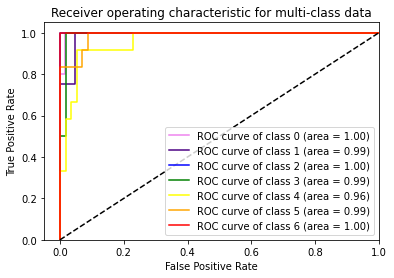

 TEST DATA 

Accuracy Score:
0.8421052631578947 

Test Error:
0.1578947368421053 

Confusion Matrix:
[[2 0 0 0 0 0 0]
 [1 1 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 1 0 2 0]
 [0 0 0 0 0 0 3]]




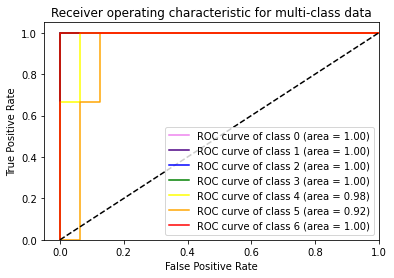

+----+--------------------+
| L  |     Acc Score      |
+----+--------------------+
| 1  | 0.856043956043956  |
| 2  | 0.7824175824175824 |
| 3  | 0.7527472527472527 |
| 4  | 0.6967032967032967 |
| 5  | 0.7538461538461538 |
| 6  | 0.6967032967032967 |
| 7  | 0.6978021978021978 |
| 8  | 0.7098901098901098 |
| 9  | 0.7538461538461538 |
| 10 | 0.7681318681318682 |
| 11 | 0.7538461538461538 |
| 12 | 0.7252747252747253 |
| 13 | 0.6527472527472528 |
| 14 | 0.710989010989011  |
| 15 | 0.7538461538461538 |
| 16 | 0.6967032967032967 |
| 17 | 0.6967032967032967 |
| 18 | 0.7252747252747253 |
| 19 | 0.7395604395604396 |
| 20 | 0.7252747252747253 |
+----+--------------------+


In [38]:
print(" GAUSSIAN NAIVE BAYES \n")
print_nb_data("Gaussian")

 MULTINOMIAL NAIVE BAYES 

Best l: 2
Accuracy Score:
0.9130434782608695 

Train Error:
0.08695652173913049 

Confusion Matrix:
[[ 4  0  0  0  1  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  1  0  1 10  0  0]
 [ 0  0  0  0  2 10  0]
 [ 0  0  0  0  0  0 12]]




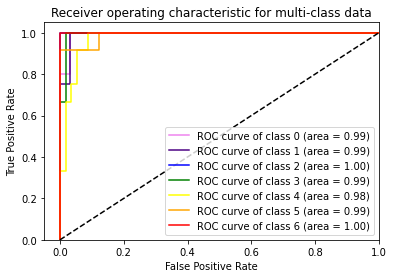

 TEST DATA 

Accuracy Score:
0.8421052631578947 

Test Error:
0.1578947368421053 

Confusion Matrix:
[[2 0 0 0 0 0 0]
 [1 1 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]




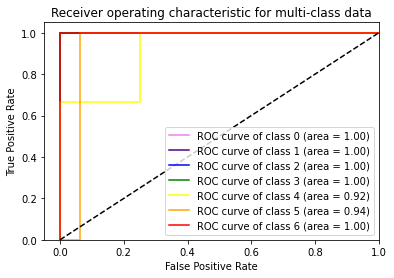

+----+--------------------+
| L  |     Acc Score      |
+----+--------------------+
| 1  | 0.810989010989011  |
| 2  | 0.8549450549450549 |
| 3  | 0.7978021978021979 |
| 4  | 0.7978021978021979 |
| 5  | 0.8549450549450549 |
| 6  | 0.8263736263736263 |
| 7  | 0.7824175824175824 |
| 8  | 0.7824175824175824 |
| 9  | 0.7978021978021979 |
| 10 | 0.7835164835164836 |
| 11 | 0.8120879120879121 |
| 12 | 0.754945054945055  |
| 13 | 0.7681318681318681 |
| 14 | 0.7692307692307693 |
| 15 | 0.7978021978021979 |
| 16 | 0.798901098901099  |
| 17 | 0.7395604395604396 |
| 18 | 0.7538461538461538 |
| 19 | 0.7846153846153847 |
| 20 | 0.7692307692307693 |
+----+--------------------+


In [39]:
print(" MULTINOMIAL NAIVE BAYES \n")
print_nb_data("Ml_nb")

### iii. Which method is better for multi-class classification in this problem?



*   L-1 Regularized Multinomial Regression with Normal scaled feature is giving the best accuracy of 94.7% on the test set. 

*   Both Gaussina NB and MultiNomial NB are giving a 84.2% accuracy on the test set.

*   L-1 Regualrized Multinomial Regression with Standard scaled feature is also giving an accuracy of 84.2% on test set.